Classification Examples

Εισάγονται οι απαραίτητες βιβλιοθήκες

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

Διαβάζουμε το αρχείο CSV και αποθηκεύουμε τα δεδομένα σε ένα DataFrame με το όνομα "data". Εκτυπώνονται οι πρώτες 5 γραμμές του Dataframe. Κρατάμε στην Βαση Δεδομένων, μόνο τις στήλες 'dif', 'distancexy', 'd3' που αποτελούν τις ανεξάρτητες μεταβλητές και 'over' που αποτελεί την εξαρτημένη μεταβλητή για την δημιουργία των προτύπων κατηγοριοποίησης

In [17]:
#Δημιουργία pandas dataframe
data = pd.read_csv('qm_moto1.csv', delimiter=';')
data= data[['dif','distancexy','d3','platoon','over']].copy()
data.head()

,dif,distancexy,d3,platoon,over
0,2,5.2,1.7,0,0
1,-6,6.6,1.7,0,0
2,-1,7.9,1.6,0,0
3,26,12.6,1.6,0,1
4,21,6.4,255.0,0,1


Διερευνητική ανάλυση δεδομένων

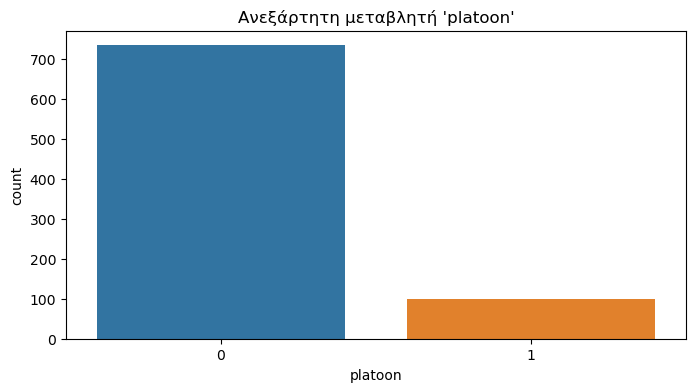

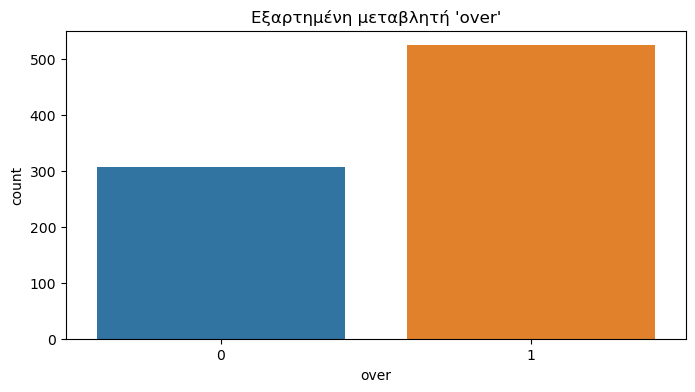

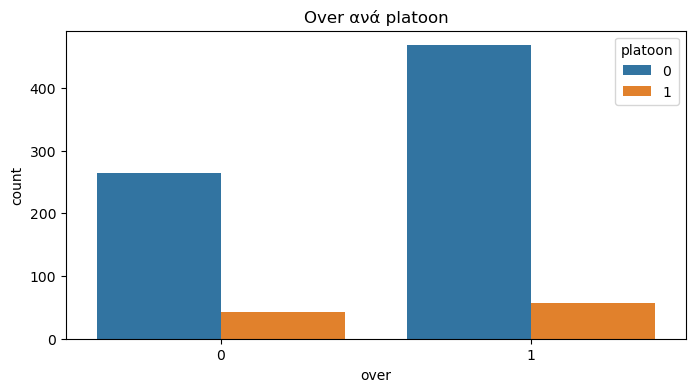

In [18]:
# Οπτικοποίηση συχνότητας ανεξάρτητης μεταβλητής platoon
plt.figure(figsize=(8, 4))
sns.countplot(x=data["platoon"])
plt.title("Ανεξάρτητη μεταβλητή 'platoon'")
plt.show()

# Οπτικοποίηση συχνότητας εξαρτημένης μεταβλητής over
plt.figure(figsize=(8, 4))
sns.countplot(x=data["over"])
plt.title("Εξαρτημένη μεταβλητή 'over'")
plt.show()

# Οπτικοποίηση συχνότητας εξαρτημένης μεταβλητής over ανά platoon κατηγορία
plt.figure(figsize=(8, 4))
sns.countplot(x="over", hue="platoon", data=data)
plt.title("Over ανά platoon")
plt.show()

Με βαση τα ανωτέρω διαγράμματα συμπεραίνεται ότι τα δεδομένα δεν είναι ανισοβαρή καθώς η εξαρτημένη μεταβλητή δεν παρουσιάζει μεγαλύτερη του 2:1 αναλογία μεταξύ των κλάσεων. Συνεπώς δεν χρειάζεται να εφαρμοστούν τεχνικές εξομάλυνσης της αναλογίας των δύο κλάσεων. Η μεταβλητή platoon πρέπει να διερευνηθεί περαιτέρω η συνεισφορά της με βάση την ακρίβεια των προτύπων που θα αναπτυχθούν

Προετοιμασία Βάσης Δεδομένων για την δημιουργία των προτύπων

In [19]:
# Καθορισμός ανεξάρτητων μεταβλητών
X = data.drop(columns="over", axis=0)

# Καθορισμός εξαρτημένης μεταβλητής
y = data["over"]

Καθαρισμός Βάσης Δεδομένων

In [20]:
# Διαγραφή ολόκληρης σειράς που εμπεριέχει NaN τιμή/ες
data = data.dropna()

# 'Ελεγχος αν υπάρχουν ακόμα NaN τιμές
data.isnull().values.any()

False

Η παραπάνω διαδικασία είναι χρήσιμη για να απαλλαγούμε από γραμμές που περιέχουν λείπουσες τιμές (NaN) και να εξασφαλίσουμε ένα συμπαγές και πλήρες σύνολο δεδομένων για ανάλυση και δημιουργία προτύπων Μηχανικής Μάθησης.

Grid search για τα επιλεγμένα πρότυπα και αποθήκευση εκείνων με τα καλύτερα hyperparameters

In [21]:
# Έναρξη προτύπων Μηχανικής Μάθησης για δυαδική κατηγοριοποίηση
log_model = LogisticRegression(max_iter=10000, random_state=0)
knn_model = KNeighborsClassifier(n_neighbors=100)
svc_model = LinearSVC(dual=False, random_state=0)
dtr_model = DecisionTreeClassifier(max_depth=3, random_state=0)
rfc_model = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=0)
gnb_model = GaussianNB()
mlp_model = MLPClassifier(hidden_layer_sizes=(30,), learning_rate='adaptive', solver='adam', alpha=0.05, max_iter=1000, random_state=0)

# Ορισμός των υπερπαραμέτρων για Grid search
param_grid = {
    'logistic regression': {'penalty': ['l1', 'l2'], 'C': [0.1, 1.0, 10.0], 'solver': ['liblinear', 'saga']},
    'knn': {'n_neighbors': [5, 10, 15], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree']},
    'svc': {'C': [0.1, 1.0, 10.0],'max_iter':[100,500,1000]},
    'decision tree': {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    'random forest': {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    'gaussian naive bayes': {},
    'mlp': {'hidden_layer_sizes': [(10,), (30,), (50,)], 'activation': [ 'relu'], 'learning_rate': ['constant', 'adaptive'], 'alpha': [0.01, 0.05, 0.1], 'max_iter': [500, 1000, 2000]}
}

best_models = {}

# Grid search με 5-fold cross-validation
for model_name, model in [('Logistic Regression', log_model), ('KNN', knn_model), ('SVC', svc_model),
                          ('Decision Tree', dtr_model), ('Random Forest', rfc_model),
                          ('Gaussian Naive Bayes', gnb_model), ('MLP', mlp_model)]:
    print(f"Performing grid search for {model_name}...")
    grid_search = GridSearchCV(model, param_grid[model_name.lower()], cv=5)
    grid_search.fit(X, y)

    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    print("-----------------------------------")

    best_models[model_name.lower().replace(' ', '_')] = grid_search.best_estimator_

# Αποθήκευση καλύτερων προτύπων με βάση το grid search με σκοπό να χρησιμοποιηθούν στο παρακάτω function
log_model = best_models['logistic_regression']
knn_model = best_models['knn']
svc_model = best_models['svc']
dtr_model = best_models['decision_tree']
rfc_model = best_models['random_forest']
gnb_model = best_models['gaussian_naive_bayes']
mlp_model = best_models['mlp']

Performing grid search for Logistic Regression...
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.8703628886804704
-----------------------------------
Performing grid search for KNN...
Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'uniform'}
Best score: 0.8559339153019263
-----------------------------------
Performing grid search for SVC...
Best parameters: {'C': 0.1, 'max_iter': 100}
Best score: 0.8679604646129429
-----------------------------------
Performing grid search for Decision Tree...
Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.8463747204386408
-----------------------------------
Performing grid search for Random Forest...
Best parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best score: 0.8631556164778876
-----------------------------------
Performing grid search for Gaussian Naive Bayes...
Best parameters: {}
Best s

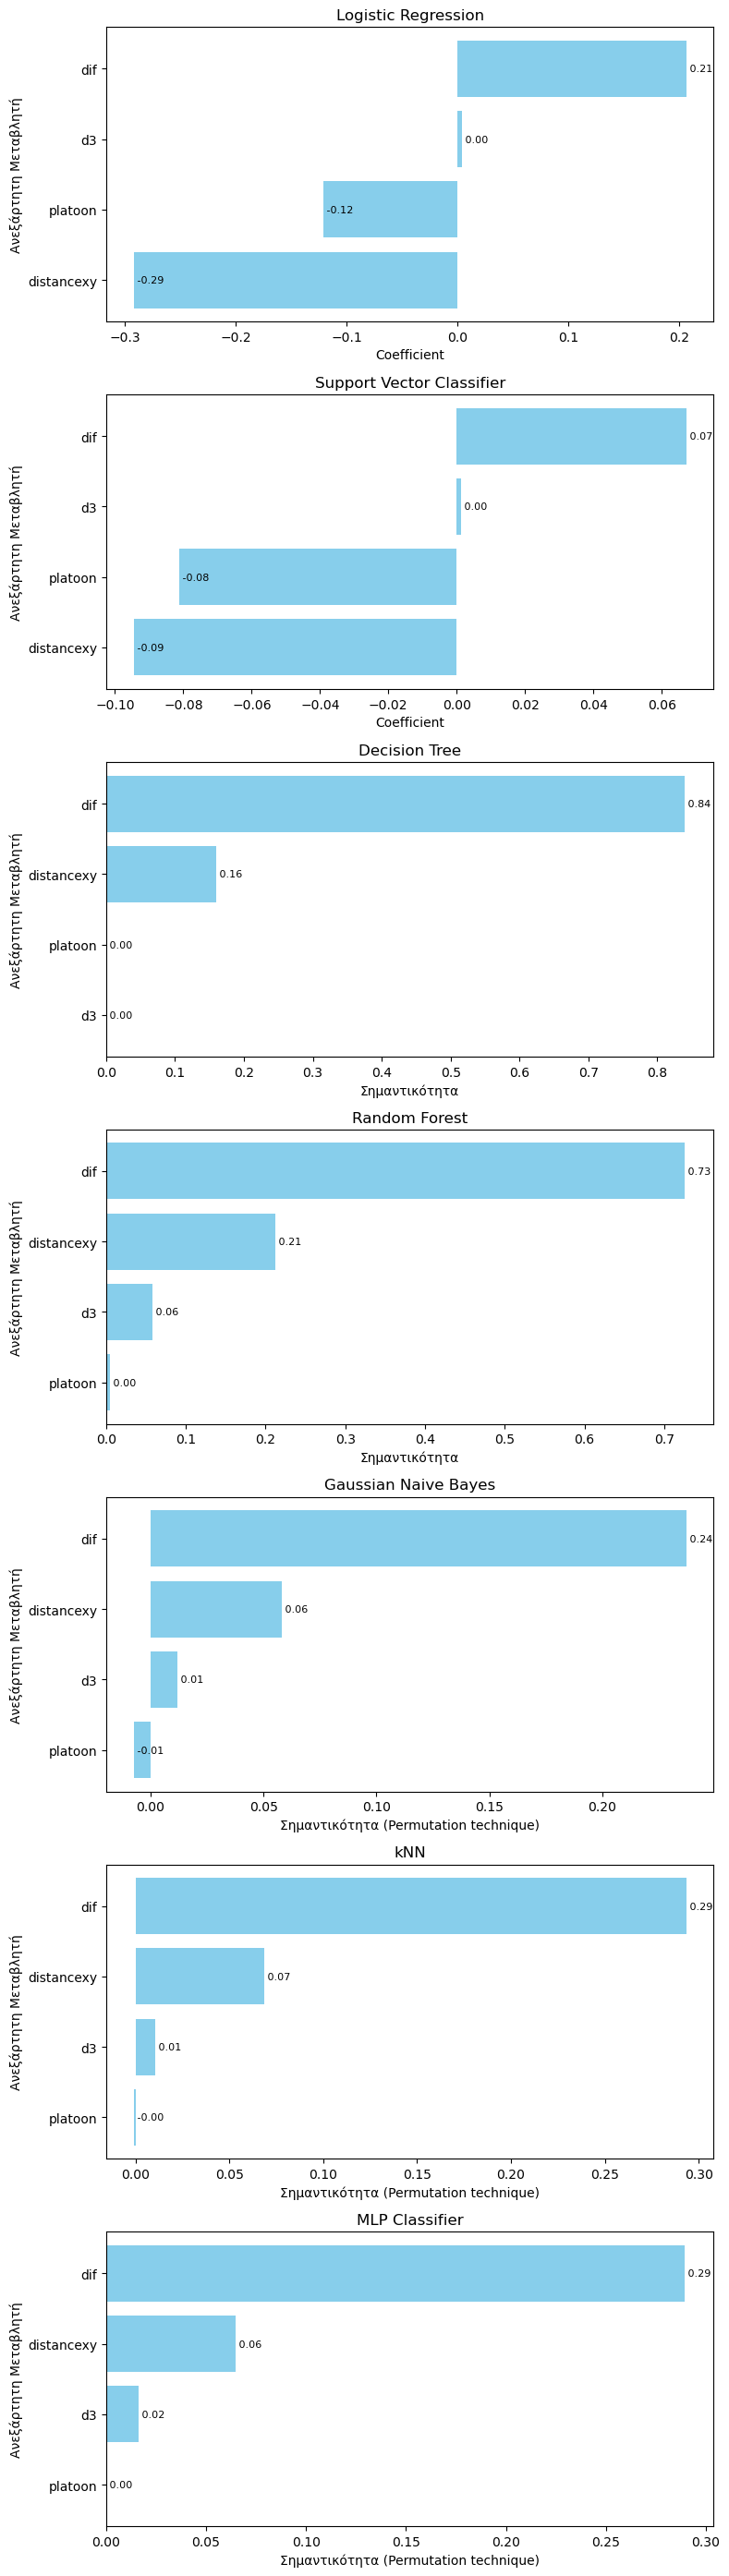

,Logistic Regression,Support Vector Classifier,Decision Tree,Random Forest,Gaussian Naive Bayes,kNN,MLP Classifier,Best Score
Accuracy,0.870363,0.867960,0.846375,0.863156,0.848741,0.855934,0.871568,MLP Classifier
Precision,0.885491,0.885077,0.854421,0.884235,0.882073,0.882291,0.891142,MLP Classifier
Recall,0.914286,0.910476,0.912381,0.902857,0.880000,0.891429,0.908571,Logistic Regression
F1 Score,0.899028,0.897036,0.882249,0.892688,0.880103,0.886371,0.899264,MLP Classifier


In [22]:
# Δημιουργία dict μετρικών αποδόσεων
scoring = {'accuracy':make_scorer(accuracy_score),
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score),
           'f1_score':make_scorer(f1_score)}

# Δημιουργία function
def models_evaluation(X, y, folds,feature_names=None):
    # Create an empty dictionary to store model results
    model_results = {}

    # Logistic Regression fit και υπολογισμός coefficients
    log_model.fit(X, y)
    log_results = cross_validate(log_model, X, y, cv=folds, scoring=scoring)
    model_results['Logistic Regression'] = log_results
    model_results['Logistic Regression']['feature_importance'] = log_model.coef_ if hasattr(log_model, 'coef_') else None

    # Support Vector Classifier και υπολογισμός coefficients
    svc_model.fit(X, y)
    svc_results = cross_validate(svc_model, X, y, cv=folds, scoring=scoring)
    model_results['Support Vector Classifier'] = svc_results
    model_results['Support Vector Classifier']['feature_importance'] = svc_model.coef_ if hasattr(svc_model, 'coef_') else None

    # Decision Tree και υπολογισμός σημαντικότητας μεταβλητών
    dtr_model.fit(X, y)
    dtr_results = cross_validate(dtr_model, X, y, cv=folds, scoring=scoring)
    model_results['Decision Tree'] = dtr_results
    model_results['Decision Tree']['feature_importance'] = dtr_model.feature_importances_ if hasattr(dtr_model, 'feature_importances_') else None

    # Random Forest και υπολογισμός σημαντικότητας μεταβλητών
    rfc_model.fit(X, y)
    rfc_results = cross_validate(rfc_model, X, y, cv=folds, scoring=scoring)
    model_results['Random Forest'] = rfc_results
    model_results['Random Forest']['feature_importance'] = rfc_model.feature_importances_ if hasattr(rfc_model, 'feature_importances_') else None

    # Gaussian Naive Bayes και υπολογισμός σημαντικότητας μεταβλητών μέσω permutation technique
    gnb_model.fit(X, y)
    gnb_results = cross_validate(gnb_model, X, y, cv=folds, scoring=scoring)
    gnb_perm_importance = permutation_importance(gnb_model, X, y, scoring=scoring)
    model_results['Gaussian Naive Bayes'] = gnb_results
    result_gnb = permutation_importance(gnb_model, X, y, n_repeats=20, random_state=0)
    model_results['Gaussian Naive Bayes']['feature_importance'] = result_gnb.importances_mean

    # k-Nearest Neighbors και υπολογισμός σημαντικότητας μεταβλητών μέσω permutation technique
    knn_model.fit(X, y)
    knn_results = cross_validate(knn_model, X, y, cv=folds, scoring=scoring)
    model_results['kNN'] = knn_results
    result_knn = permutation_importance(knn_model, X, y, n_repeats=20, random_state=0)
    model_results['kNN']['feature_importance'] = result_knn.importances_mean

    # MLP Classifier και υπολογισμός σημαντικότητας μεταβλητών μέσω permutation technique
    mlp_model.fit(X, y)
    mlp_results = cross_validate(mlp_model, X, y, cv=folds, scoring=scoring)
    model_results['MLP Classifier'] = mlp_results
    result_mlp = permutation_importance(mlp_model, X, y, n_repeats=20, random_state=0)
    model_results['MLP Classifier']['feature_importance'] = result_mlp.importances_mean

    # Δημιουργία ενός dataframe με μετρήσεις επιδόσεων
    models_scores_table = pd.DataFrame({
        'Logistic Regression': [
            log_results['test_accuracy'].mean(),
            log_results['test_precision'].mean(),
            log_results['test_recall'].mean(),
            log_results['test_f1_score'].mean()
        ],
        'Support Vector Classifier': [
            svc_results['test_accuracy'].mean(),
            svc_results['test_precision'].mean(),
            svc_results['test_recall'].mean(),
            svc_results['test_f1_score'].mean()
        ],
        'Decision Tree': [
            dtr_results['test_accuracy'].mean(),
            dtr_results['test_precision'].mean(),
            dtr_results['test_recall'].mean(),
            dtr_results['test_f1_score'].mean()
        ],
        'Random Forest': [
            rfc_results['test_accuracy'].mean(),
            rfc_results['test_precision'].mean(),
            rfc_results['test_recall'].mean(),
            rfc_results['test_f1_score'].mean()
        ],
        'Gaussian Naive Bayes': [
            gnb_results['test_accuracy'].mean(),
            gnb_results['test_precision'].mean(),
            gnb_results['test_recall'].mean(),
            gnb_results['test_f1_score'].mean()
        ],
        'kNN': [
            knn_results['test_accuracy'].mean(),
            knn_results['test_precision'].mean(),
            knn_results['test_recall'].mean(),
            knn_results['test_f1_score'].mean()
        ],
        'MLP Classifier': [
            mlp_results['test_accuracy'].mean(),
            mlp_results['test_precision'].mean(),
            mlp_results['test_recall'].mean(),
            mlp_results['test_f1_score'].mean()
        ]
    }, index=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

    # Προσθήκη στήλης που υποδεικνύει την καλύτερη βαθμολογία για κάθε μέτρηση
    models_scores_table['Best Score'] = models_scores_table.idxmax(axis=1)

    # Δημιουργία γραφημάτων σημαντικότητας μεταβλητών
    fig, axs = plt.subplots(nrows=len(model_results), figsize=(8, 4 * len(model_results)))

    for i, (model_name, results) in enumerate(model_results.items()):
     if model_name == 'Logistic Regression' or model_name == 'Support Vector Classifier':
        if results['feature_importance'] is not None:
            importances = results['feature_importance'][0]

            # Ταξινόμηση της σημαντικότητας των μεταβλητών και των αντίστοιχων ονομάτων μεταβλητών
            sorted_indices = np.argsort(importances)
            sorted_importances = importances[sorted_indices]
            sorted_features = np.array(X.columns)[sorted_indices]

            axs[i].barh(range(len(importances)), sorted_importances,color='skyblue')
            axs[i].set_yticks(range(len(importances)))
            axs[i].set_yticklabels(sorted_features)
            axs[i].set_ylabel('Ανεξάρτητη Μεταβλητή')
            axs[i].set_xlabel('Coefficient')
            axs[i].set_title(model_name)

            # Προσθήκη της ακριβούς τιμής στο τέλος κάθε bar
            for j, imp in enumerate(sorted_importances):
                axs[i].text(imp, j, f' {imp:.2f}', ha='left', va='center', fontsize=8)

        else:
            axs[i].text(0.5, 0.5, 'No feature importance available', ha='center', va='center', fontsize=12,
                        color='red')
            axs[i].axis('off')
     else:
        if results['feature_importance'] is not None:
            if hasattr(results['feature_importance'], 'shape') and len(results['feature_importance'].shape) > 1:
                importances = results['feature_importance'][0]
            else:
                importances = results['feature_importance']

            # Ταξινόμηση της σημαντικότητας των μεταβλητών και των αντίστοιχων ονομάτων μεταβλητών
            sorted_indices = np.argsort(importances)
            sorted_importances = importances[sorted_indices]
            sorted_features = np.array(feature_names)[sorted_indices]

            axs[i].barh(range(len(importances)), sorted_importances,color='skyblue')
            axs[i].set_yticks(range(len(importances)))
            axs[i].set_yticklabels(sorted_features)
            axs[i].set_ylabel('Ανεξάρτητη Μεταβλητή')
            if model_name == 'Decision Tree' or model_name == 'Random Forest':
             axs[i].set_xlabel('Σημαντικότητα')
            else:
             axs[i].set_xlabel('Σημαντικότητα (Permutation technique)')
            axs[i].set_title(model_name)

            # Προσθήκη της ακριβούς τιμής στο τέλος κάθε bar
            for j, imp in enumerate(sorted_importances):
                axs[i].text(imp, j, f' {imp:.2f}', ha='left', va='center', fontsize=8)

        else:
            axs[i].text(0.5, 0.5, 'No feature importance available', ha='center', va='center', fontsize=12,
                        color='red')
            axs[i].axis('off')


    plt.tight_layout()
    plt.show()

    # Επιστροφή του dataframe με τις μετρήσεις επιδόσεων
    return models_scores_table

# Εκτέλεση του παραπάνω function
models_evaluation(X, y, 5, feature_names=X.columns)

Σύμφωνα με τα αποτελέσματα από τον παραπάνω πίνακα, το MLP Classifier
πέτυχε τα καλύτερα σκορ (accuracy, recall, f1 score)  καθιστώντας τον τον πιο αξιόπιστο ταξινομητή Mηχανικής Mάθησης για αυτό το σύνολο δεδομένων. Επιπλέον διαφαίνεται από τα περισσότερα πρότυπα και τις αντίστοιχες σημαντικότητων των μεταβλητών τους πως το dif αποτελεί την σημαντικότερη μεταβλητή ακολουθούμενη από το distancexy

ROC curve για το καλύτερο πρότυπο

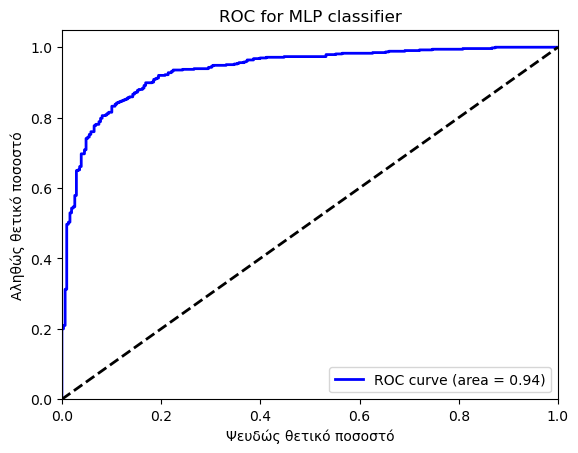

In [23]:
# Fit the MLP Classifier
mlp_model.fit(X, y)

# Εκτέλεση εκτιμήσεων
y_pred_proba = mlp_model.predict_proba(X)[:, 1]

# Υπολογισμός του ψευδώς θετικού ποσοστού, του αληθώς θετικού ποσοστού και των thresholds
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)

# Υπολογισμός της περιοχής κάτω από την καμπύλη ROC
roc_auc = auc(fpr, tpr)

# Δημιουργία ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ψευδώς θετικό ποσοστό')
plt.ylabel('Αληθώς θετικό ποσοστό')
plt.title('ROC for MLP classifier')
plt.legend(loc="lower right")
plt.show()

H βαθμολογία AUC=0,94 θεωρείται γενικά αρκετά καλή και ενδεικτική ενός ισχυρού προγνωστικού μοντέλου καθώς η τιμή κυμαίνεται μεταξύ 0-1 με το 1 να επιδυκνύει άριστη επίδοση

In [24]:
models = {
    'Logistic Regression': log_model,
    'KNN': knn_model,
    'SVC': svc_model,
    'Decision Tree': dtr_model,
    'Random Forest': rfc_model,
    'Gaussian Naive Bayes': gnb_model,
    'MLP': mlp_model
}

# Εκτύπωση specification των προτύπων
for model_name, model in models.items():
    print("Model:", model_name)
    print("Specification:")
    for param, value in model.get_params().items():
        print(param + ": " + str(value))
    print()


Model: Logistic Regression
Specification:
C: 0.1
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
l1_ratio: None
max_iter: 10000
multi_class: auto
n_jobs: None
penalty: l2
random_state: 0
solver: liblinear
tol: 0.0001
verbose: 0
warm_start: False

Model: KNN
Specification:
algorithm: ball_tree
leaf_size: 30
metric: minkowski
metric_params: None
n_jobs: None
n_neighbors: 10
p: 2
weights: uniform

Model: SVC
Specification:
C: 0.1
class_weight: None
dual: False
fit_intercept: True
intercept_scaling: 1
loss: squared_hinge
max_iter: 100
multi_class: ovr
penalty: l2
random_state: 0
tol: 0.0001
verbose: 0

Model: Decision Tree
Specification:
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: 3
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
random_state: 0
splitter: best

Model: Random Forest
Specification:
bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini